In [1]:
import os
import PIL
import json
import pickle
import numpy as np
from math import log, exp
from tqdm import tqdm
from random import shuffle
from PIL import ImageEnhance, ImageFont, ImageDraw
from IPython.display import Image, display
from multiprocessing import Pool

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.utils.data_utils import Sequence

tf.keras.backend.clear_session()  # For easy reset of notebook state.

cat_list = ['tops', 'trousers', 'outerwear', 'dresses', 'skirts']

input_shape = (224,224,3)
wt_decay = 5e-4

dims_list = [(7,7),(14,14)]
aspect_ratios = [(1,1), (1,2), (2,1)]

base_folder = '/kaggle'
data_folder = os.path.join( base_folder, 'input', 'til2020-test' )
train_imgs_folder = os.path.join( data_folder, 'train', 'train' )
train_annotations = os.path.join( data_folder, 'train_final.json' )
val_imgs_folder = os.path.join( data_folder, 'train', 'train' )
val_annotations = os.path.join( data_folder, 'val_final.json' )

train_pickle = os.path.join( data_folder, 'train.p' )
val_pickle = os.path.join( data_folder, 'val.p' )

save_model_folder = os.path.join( base_folder, 'working' )
load_model_folder = data_folder

In [5]:
tf.__version__

'2.1.0'

# Data Augmentation Methods

In [6]:
'''
Augmentation methods. We need to implement our own augmentation because native support in keras does not change the bounding box 
labels for us as the image is altered. We need to do it ourselves.
'''
# Helper method: Computes the boundary of the image that includes all bboxes
def compute_reasonable_boundary(labels):
  bounds = [ (x-w/2, x+w/2, y-h/2, y+h/2) for _,x,y,w,h in labels]
  xmin = min([bb[0] for bb in bounds])
  xmax = max([bb[1] for bb in bounds])
  ymin = min([bb[2] for bb in bounds])
  ymax = max([bb[3] for bb in bounds])
  return xmin, xmax, ymin, ymax

def aug_horizontal_flip(img, labels):
  flipped_labels = []
  for c,x,y,w,h in labels:
    flipped_labels.append( (c,1-x,y,w,h) )
  return img.transpose(PIL.Image.FLIP_LEFT_RIGHT), np.array(flipped_labels)

def aug_crop(img, labels):
  # Compute bounds such that no boxes are cut out
  xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
  # Choose crop_xmin from [0, xmin]
  crop_xmin = max( np.random.uniform() * xmin, 0 )
  # Choose crop_xmax from [xmax, 1]
  crop_xmax = min( xmax + (np.random.uniform() * (1-xmax)), 1 )
  # Choose crop_ymin from [0, ymin]
  crop_ymin = max( np.random.uniform() * ymin, 0 )
  # Choose crop_ymax from [ymax, 1]
  crop_ymax = min( ymax + (np.random.uniform() * (1-ymax)), 1 )
  # Compute the "new" width and height of the cropped image
  crop_w = crop_xmax - crop_xmin
  crop_h = crop_ymax - crop_ymin
  cropped_labels = []
  for c,x,y,w,h in labels:
    c_x = (x - crop_xmin) / crop_w
    c_y = (y - crop_ymin) / crop_h
    c_w = w / crop_w
    c_h = h / crop_h
    cropped_labels.append( (c,c_x,c_y,c_w,c_h) )

  W,H = img.size
  # Compute the pixel coordinates and perform the crop
  impix_xmin = int(W * crop_xmin)
  impix_xmax = int(W * crop_xmax)
  impix_ymin = int(H * crop_ymin)
  impix_ymax = int(H * crop_ymax)
  return img.crop( (impix_xmin, impix_ymin, impix_xmax, impix_ymax) ), np.array( cropped_labels )

def aug_translate(img, labels):
  # Compute bounds such that no boxes are cut out
  xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
  trans_range_x = [-xmin, 1 - xmax]
  tx = trans_range_x[0] + (np.random.uniform() * (trans_range_x[1] - trans_range_x[0]))
  trans_range_y = [-ymin, 1 - ymax]
  ty = trans_range_y[0] + (np.random.uniform() * (trans_range_y[1] - trans_range_y[0]))

  trans_labels = []
  for c,x,y,w,h in labels:
    trans_labels.append( (c,x+tx,y+ty,w,h) )

  W,H = img.size
  tx_pix = int(W * tx)
  ty_pix = int(H * ty)
  return img.rotate(0, translate=(tx_pix, ty_pix)), np.array( trans_labels )

def aug_colorbalance(img, labels, color_factors=[0.2,2.0]):
  factor = color_factors[0] + np.random.uniform() * (color_factors[1] - color_factors[0])
  enhancer = ImageEnhance.Color(img)
  return enhancer.enhance(factor), labels

def aug_contrast(img, labels, contrast_factors=[0.2,2.0]):
  factor = contrast_factors[0] + np.random.uniform() * (contrast_factors[1] - contrast_factors[0])
  enhancer = ImageEnhance.Contrast(img)
  return enhancer.enhance(factor), labels

def aug_brightness(img, labels, brightness_factors=[0.2,2.0]):
  factor = brightness_factors[0] + np.random.uniform() * (brightness_factors[1] - brightness_factors[0])
  enhancer = ImageEnhance.Brightness(img)
  return enhancer.enhance(factor), labels

def aug_sharpness(img, labels, sharpness_factors=[0.2,10.0]):
  factor = sharpness_factors[0] + np.random.uniform() * (sharpness_factors[1] - sharpness_factors[0])
  enhancer = ImageEnhance.Sharpness(img)
  return enhancer.enhance(factor), labels

# Performs no augmentations and returns the original image and bbox. Used for the validation images.
def aug_identity(pil_img, label_arr):
  return np.array(pil_img), label_arr

# This is the default augmentation scheme that we will use for each training image.
def aug_default(img, labels, p={'flip':0.5, 'crop':0.5, 'translate':0.5, 'color':0.2, 'contrast':0.2, 'brightness':0.2, 'sharpness':0.2}):
  if p['color'] > np.random.uniform():
    img, labels = aug_colorbalance(img, labels)
  if p['contrast'] > np.random.uniform():
    img, labels = aug_contrast(img, labels)
  if p['brightness'] > np.random.uniform():
    img, labels = aug_brightness(img, labels)
  if p['sharpness'] > np.random.uniform():
    img, labels = aug_sharpness(img, labels)
  
  if p['flip'] > np.random.uniform():
    img, labels = aug_horizontal_flip(img, labels)
  if p['crop'] > np.random.uniform():
    img, labels = aug_crop(img, labels)
  if p['translate'] > np.random.uniform():
    img, labels = aug_translate(img, labels)
  return np.array(img), labels

# Custom Loss Function

In [7]:
# Shape of ypred: ( batch, i, j, aspect_ratios, 7 ). For a batch,i,j, we get #aspect_ratios vectors of length 7.
# Shape of ytrue: ( batch, i, j, aspect_ratios, 9 ). For a batch,i,j, we get #aspect_ratios vectors of length 9 (two more for objectness and cat/loc indicators)
def custom_loss(ytrue, ypred):
  obj_loss_weight = 1.0
  cat_loss_weight = 1.0
  loc_loss_weight = 1.0

  end_cat = len(cat_list) + 1

  objloss_indicators = ytrue[:,:,:,:,-2:-1]
  catlocloss_indicators = ytrue[:,:,:,:,-1:]

  ytrue_obj, ypred_obj = ytrue[:,:,:,:,:1], ypred[:,:,:,:,:1]
  ytrue_obj = tf.where( objloss_indicators != 0, ytrue_obj, 0 )
  ypred_obj = tf.where( objloss_indicators != 0, ypred_obj, 0 )
  objectness_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)( ytrue_obj, ypred_obj )

  ytrue_cat, ypred_cat = ytrue[:,:,:,:,1:end_cat], ypred[:,:,:,:,1:end_cat]
  ytrue_cat = tf.where( catlocloss_indicators != 0, ytrue_cat, 0 )
  ypred_cat = tf.where( catlocloss_indicators != 0, ypred_cat, 0 )
  categorical_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) ( ytrue_cat, ypred_cat )

  # Remember that ytrue is longer than ypred, so we will need to stop at index -2, which is where the indicators are stored
  ytrue_loc, ypred_loc = ytrue[:,:,:,:,end_cat:-2], ypred[:,:,:,:,end_cat:]
  ytrue_loc = tf.where( catlocloss_indicators != 0, ytrue_loc, 0 )
  ypred_loc = tf.where( catlocloss_indicators != 0, ypred_loc, 0 )
  localisation_loss = tf.keras.losses.Huber() ( ytrue_loc, ypred_loc )

  return obj_loss_weight*objectness_loss + cat_loss_weight*categorical_loss + loc_loss_weight*localisation_loss


In [18]:
# Computes the intersection-over-union (IoU) of two bounding boxes
def iou(bb1, bb2):
  x1,y1,w1,h1 = bb1
  xmin1 = x1 - w1/2
  xmax1 = x1 + w1/2
  ymin1 = y1 - h1/2
  ymax1 = y1 + h1/2

  x2,y2,w2,h2 = bb2
  xmin2 = x2 - w2/2
  xmax2 = x2 + w2/2
  ymin2 = y2 - h2/2
  ymax2 = y2 + h2/2

  area1 = w1*h1
  area2 = w2*h2

  # Compute the boundary of the intersection
  xmin_int = max( xmin1, xmin2 )
  xmax_int = min( xmax1, xmax2 )
  ymin_int = max( ymin1, ymin2 )
  ymax_int = min( ymax1, ymax2 )
  intersection = max(xmax_int - xmin_int, 0) * max( ymax_int - ymin_int, 0 )

  # Remove the double counted region
  union = area1+area2-intersection

  return intersection / union


# Sampling Schemes

In [8]:
# Sampling schemes
def yolo_posneg_sampling(iou_scores_dict, label_tensor, gtclass, cat_list, iou_threshold=0.5):
  iou_scores = []
  for _, scores in iou_scores_dict.items():
    iou_scores.extend(scores)
  iou_scores.sort( key=lambda x: x[0], reverse=True )
  
  top_iou_score = iou_scores.pop(0)
  _, key, i, j, k, dx, dy, dw, dh = top_iou_score
  zeros = [0] * len(cat_list)
  payload = [1, *zeros, dx,dy,dw,dh]
  payload[gtclass + 1] = 1
  # Train objectness, class and loc for the positive
  label_tensor[key][i,j,k,-2:] = 1
  label_tensor[key][i,j,k,:len(payload)] = payload

  # Train objectness only for the negatives
  low_iou_scores = [iou_score for iou_score in iou_scores if iou_score[0] < iou_threshold]
  for _, key, i, j, k, _, _, _, _ in low_iou_scores:
    label_tensor[key][i,j,k,-2] = 1

def modified_yolo_posneg_sampling(iou_scores_dict, label_tensor, gtclass, cat_list, iou_threshold=0.5):
  iou_scores = []
  zeros = [0] * len(cat_list)

  for _, scores in iou_scores_dict.items():
    iou_scores.extend(scores)
  iou_scores.sort( key=lambda x: x[0], reverse=True )
  
  top_iou_score = iou_scores.pop(0)
  _, key, i, j, k, dx, dy, dw, dh = top_iou_score
  payload = [1, *zeros, dx,dy,dw,dh]
  payload[gtclass + 1] = 1
  # Train objectness, class and loc for the positive
  label_tensor[key][i,j,k,-2:] = 1
  label_tensor[key][i,j,k,:len(payload)] = payload

  # Train objectness only for the negatives
  low_iou_scores = [iou_score for iou_score in iou_scores if iou_score[0] < iou_threshold]
  for _, key, i, j, k, _, _, _, _ in low_iou_scores:
    label_tensor[key][i,j,k,-2] = 1

  # Train cat/loc only for the in-betweens - those with high IoU but not positive
  high_iou_scores = [iou_score for iou_score in iou_scores if iou_score[0] >= iou_threshold]
  for _, key, i, j, k, dx, dy, dw, dh in high_iou_scores:
    label_tensor[key][i,j,k,-1] = 1
    payload = [0,*zeros,dx,dy,dw,dh]
    payload[gtclass + 1] = 1
    label_tensor[key][i,j,k,:len(payload)] = payload

def top_ratio_sampling(iou_scores_dict, label_tensor, gtclass, cat_list, positive_ratio=0.25):
  iou_scores = []
  # Let all tensors learn objectness score
  for v in label_tensor.values():
    v[:,:,:,-2] = 1
  
  for _, iou_score_list in iou_scores_dict.items():
    iou_score_list.sort( key=lambda x: x[0], reverse=True )
    top_percentile_iou_scores = iou_score_list[:round(len(iou_score_list) * positive_ratio)]
    # Include the rest that cross the IoU threshold
    iou_score_list = top_percentile_iou_scores + [iou_score for iou_score in iou_score_list[len(top_percentile_iou_scores):] if iou_score[0] >= self.iou_threshold]
    iou_scores.extend( iou_score_list )

  for iou_score in iou_scores:
    IoU, key, i, j, k, dx, dy, dw, dh = iou_score
    zeros = [0] * len(cat_list)
    payload = [IoU, *zeros, dx,dy,dw,dh]
    payload[gtclass + 1] = 1
    label_tensor[key][i,j,k,:len(payload)] = payload
    # Set the classification/localisation indicator at this location to positive
    label_tensor[key][i,j,k,-1] = 1


# Encoding labels / Decoding model output

In [9]:
'''
Encoder: label -> tensor
label_arr: np array like:
[[class_idx x y w h]]: num_labels x 5
...  
Used to figure out for each label line, which tensor entry to shove it into.
If the box corresponding to the tensor entry overlaps the ground truth by at least a predefined threshold, then we shove it in.
'''
def encode_label(label_arr, dims_list, aspect_ratios, iou_fn, sampling_fn, cat_list):
  num_entries = 7 + len(cat_list) # objectness, ... len(cat_list) ..., dx, dy, dw, dh, obj_indicator, catloc_indicator
  np_labels = {}
  for dims in dims_list:
    dimkey = '{}x{}'.format(*dims)
    np_labels[dimkey] = np.zeros( (*dims, len(aspect_ratios), num_entries ) )

  for label in label_arr:
    gtclass, gtx, gty, gtw, gth = label
    gtclass = int(gtclass)
    gt_bbox = [gtx, gty, gtw, gth]
    
    iou_scores_dict = {}

    for dims in dims_list:
      key = '{}x{}'.format(*dims)
    
      kx,ky = dims
      gapx = 1.0 / kx
      gapy = 1.0 / ky
      '''
      There are kx x ky tiles. 
      For now, all have the same w,h of gapx,gapy. 
      For the (i,j)-th tile, x = 0.5*gapx + i*gapx = (0.5+i)*gapx | y = (0.5+j)*gapy
      '''
      for i in range(kx):
        for j in range(ky):
          for k in range( len(aspect_ratios) ):
            dims_aspect_key = (*dims, k) # a 3-tuple: (dim1,dim2,ar)
            if dims_aspect_key not in iou_scores_dict:
              iou_scores_dict[dims_aspect_key] = []
            x = (0.5+i)*gapx
            y = (0.5+j)*gapy

            # Different aspect ratios alter the anchor box default dimensions
            w = gapx * aspect_ratios[k][0]
            h = gapy * aspect_ratios[k][1]
            cand_bbox = [x,y,w,h]

            # SSD formulation
            dx = (gtx - x) / w 
            dy = (gty - y) / h
            dw = log( gtw / w )
            dh = log( gth / h )
            
            int_over_union = iou_fn( cand_bbox, gt_bbox )
            iou_scores_dict[dims_aspect_key].append( (int_over_union, key, i, j, k, dx, dy, dw, dh) )
      sampling_fn( iou_scores_dict, np_labels, gtclass, cat_list )
  return np_labels

def decode_tensor(pred_dict, aspect_ratios):
  results = []
  for dim_str, pred_tensor in pred_dict.items():
    pred_tensor = pred_tensor[0] # remove the batch
    kx, ky = [int(g) for g in dim_str.split('x')]
    gapx = 1. / kx
    gapy = 1. / ky

    # We trained without activations, so we need to process the logits into probabilities/scores
    pred_arr = np.array(pred_tensor)
    obj_logits = pred_arr[:,:,:,0]
    obj_scores = 1. / (1 + np.exp(-obj_logits))
    pred_arr[:,:,:,0] = obj_scores
    
    cls_logits = pred_arr[:,:,:,1:-4]
    cls_scores = np.exp(cls_logits)
    cls_scores = cls_scores / cls_scores.sum(axis=-1)[...,np.newaxis]
    pred_arr[:,:,:,1:-4] = cls_scores

    for k, ar in enumerate(aspect_ratios):
      for i in range(kx):
        for j in range(ky):
          cx = (0.5+i)*gapx
          cy = (0.5+j)*gapy
          w = gapx * ar[0]
          h = gapy * ar[1]

          payload = pred_arr[i,j,k]
          obj_score = payload[0]
          dx, dy, dw, dh = payload[-4:]
          cls_probs = payload[1:-4]

          predx = (dx * w) + cx
          predy = (dy * h) + cy
          predw = w * exp( dw )
          predh = h * exp( dh )
          max_cls_idx = np.argmax( cls_probs )
          max_cls_prob = cls_probs[max_cls_idx]
          category_id = max_cls_idx + 1
          det_score = obj_score * max_cls_prob
          results.append( (det_score, category_id, predx, predy, predw, predh) )
  return results

# Constructing models

In [10]:
def transfer_model(backbone_model, input_shape, dims_list, num_aspect_ratios, wt_decay, model_name='transfer-objdet-model'):
  inputs = keras.Input(shape=input_shape)
  backbone_output = backbone_model(inputs) #7

  x = layers.Conv2D(512, 1, padding='same', kernel_regularizer=l2(wt_decay))(backbone_output) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='valid', kernel_regularizer=l2(wt_decay))(x) #5
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #5
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='valid', kernel_regularizer=l2(wt_decay))(x) #3
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)

  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #3
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #3
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)

  # You can accumulate more scales via shortcut. Imagine each (n,m) is a grid super-imposed on the original image.
  # See the next cell for an example for more scales.
  dim_tensor_map = {'3x3': x}

  # For each dimension, construct a predictions tensor. Accumulate them into a dictionary for keras to understand multiple labels.
  preds_dict = {}
  for dims in dims_list:
    dimkey = '{}x{}'.format(*dims)
    tens = dim_tensor_map[dimkey]
    ar_preds = []
    for _ in range(num_aspect_ratios):
      objectness_preds = layers.Conv2D(1, 1, kernel_regularizer=l2(wt_decay))( tens )
      class_preds = layers.Conv2D(len(cat_list), 1, kernel_regularizer=l2(wt_decay))( tens )
      bbox_preds = layers.Conv2D(4, 1, kernel_regularizer=l2(wt_decay))( tens )
      ar_preds.append( layers.Concatenate()([objectness_preds, class_preds, bbox_preds]) )

    if num_aspect_ratios > 1:
      predictions = layers.Concatenate()(ar_preds)
    elif num_aspect_ratios == 1:
      predictions = ar_preds[0]
    
    predictions = layers.Reshape( (*dims, num_aspect_ratios, 5+len(cat_list)), name=dimkey )(predictions)
    preds_dict[dimkey] = predictions

  model = keras.Model(inputs, preds_dict, name=model_name)

  model.compile( optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss=custom_loss )
  return model

In [11]:
def transfer_model_7x7_14x14(backbone_model, input_shape, dims_list, num_aspect_ratios, wt_decay, model_name='transfer-objdet-model-7x7-14x14'):
  inputs = keras.Input(shape=input_shape)
  intermediate_layer_model = keras.Model(inputs=backbone_model.input,
                                         outputs=backbone_model.get_layer('conv4_block6_out').output)
  intermediate_output = intermediate_layer_model(inputs) #14
  backbone_output = backbone_model(inputs) #7

  x = layers.Conv2D(512, 1, padding='same', kernel_regularizer=l2(wt_decay))(backbone_output) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(1024, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(1024, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #7
  x = layers.BatchNormalization()(x)
  upsample = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(2048, 3, padding='same', kernel_regularizer=l2(wt_decay))(upsample) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  tens_7x7 = layers.Add()([x,backbone_output])

  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(upsample) #7
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2DTranspose(512, 5, strides=(2, 2), padding='same')(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)

  x = layers.Concatenate()([x,intermediate_output])

  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.01)(x)
  x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
  x = layers.BatchNormalization()(x)
  tens_14x14 = layers.LeakyReLU(0.01)(x)

  dim_tensor_map = {'7x7': tens_7x7, '14x14': tens_14x14}

  # For each dimension, construct a predictions tensor. Accumulate them into a dictionary for keras to understand multiple labels.
  preds_dict = {}
  for dims in dims_list:
    dimkey = '{}x{}'.format(*dims)
    tens = dim_tensor_map[dimkey]
    ar_preds = []
    for _ in range(num_aspect_ratios):
      objectness_preds = layers.Conv2D(1, 1, kernel_regularizer=l2(wt_decay))( tens )
      class_preds = layers.Conv2D(len(cat_list), 1, kernel_regularizer=l2(wt_decay))( tens )
      bbox_preds = layers.Conv2D(4, 1, kernel_regularizer=l2(wt_decay))( tens )
      ar_preds.append( layers.Concatenate()([objectness_preds, class_preds, bbox_preds]) )

    if num_aspect_ratios > 1:
      predictions = layers.Concatenate()(ar_preds)
    elif num_aspect_ratios == 1:
      predictions = ar_preds[0]
    
    predictions = layers.Reshape( (*dims, num_aspect_ratios, 5+len(cat_list)), name=dimkey )(predictions)
    preds_dict[dimkey] = predictions

  model = keras.Model(inputs, preds_dict, name=model_name)

  model.compile( optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss=custom_loss )
  return model

# Data generators

In [15]:
class TILSequence(Sequence):
  def __init__(self, img_folder, json_annotation_file, batch_size, augment_fn, input_size, label_encoder, preprocess_fn, testmode=False):

    self._prepare_data(img_folder, json_annotation_file)
    self.batch_size = batch_size
    self.augment_fn = augment_fn
    self.input_wh = (*input_size[:2][::-1],input_size[2])
    self.label_encoder = label_encoder
    self.preprocess_fn = preprocess_fn
    self.testmode = testmode
    
  def _prepare_data(self, img_folder, json_annotation_file):
    imgs_dict = {im.split('.')[0]:im for im in os.listdir(img_folder) if im.endswith('.jpg')}
    data_dict = {}
    with open(json_annotation_file, 'r') as f:
      annotations_dict = json.load(f)
    annotations_list = annotations_dict['annotations']
    for annotation in annotations_list:
      img_id = str(annotation['image_id'])
      c = annotation['category_id'] - 1 # TODO: make sure that category ids start from 1, not 0
      boxleft,boxtop,boxwidth,boxheight = annotation['bbox']
      if img_id in imgs_dict:
        img_fp = os.path.join(img_folder, imgs_dict[img_id])
        imwidth,imheight = PIL.Image.open(img_fp).size
        if img_id not in data_dict:
          data_dict[img_id] = []
        box_cenx = boxleft + boxwidth/2.
        box_ceny = boxtop + boxheight/2.
        x,y,w,h = box_cenx/imwidth, box_ceny/imheight, boxwidth/imwidth, boxheight/imheight

        data_dict[img_id].append( [c,x,y,w,h] )
    self.x, self.y, self.ids = [], [], []
    for img_id, labels in data_dict.items():
      self.x.append( os.path.join(img_folder, imgs_dict[img_id]) )
      self.y.append( np.array(labels) )
      self.ids.append( img_id )

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))
  
  def __getitem__(self, idx):
    return self.get_batch_test(idx) if self.testmode else self.get_batch(idx)

  def get_batch_test(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_ids = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]

    x_acc, y_acc = [], {}
    original_img_dims = []
    with Pool(self.batch_size) as p:
      # Read in the PIL objects from filepaths
      batch_x = p.map(load_img, batch_x)
    
    for x,y in zip( batch_x, batch_y ):
      W,H = x.size
      original_img_dims.append( (W,H) )
      x_aug, y_aug = self.augment_fn( x, y )
      if x_aug.size != self.input_wh[:2]:
        x_aug.resize( self.input_wh )
      x_acc.append( np.array(x_aug) )
      y_dict = self.label_encoder( y_aug )
      for dimkey, label in y_dict.items():
        if dimkey not in y_acc:
          y_acc[dimkey] = []
        y_acc[dimkey].append( label )

    return batch_ids, original_img_dims, self.preprocess_fn( np.array( x_acc ) ), { dimkey: np.array( gt_tensor ) for dimkey, gt_tensor in y_acc.items() }

  def get_batch(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    x_acc, y_acc = [], {}
    with Pool(self.batch_size) as p:
      # Read in the PIL objects from filepaths
      batch_x = p.map(load_img, batch_x)
    
    for x,y in zip( batch_x, batch_y ):
      x_aug, y_aug = self.augment_fn( x, y )
      if x_aug.size != self.input_wh[:2]:
        x_aug.resize( self.input_wh )
      x_acc.append( np.array(x_aug) )
      y_dict = self.label_encoder( y_aug )
      for dimkey, label in y_dict.items():
        if dimkey not in y_acc:
          y_acc[dimkey] = []
        y_acc[dimkey].append( label )

    return self.preprocess_fn( np.array( x_acc ) ), { dimkey: np.array( gt_tensor ) for dimkey, gt_tensor in y_acc.items() }



In [14]:
class TILPickle(Sequence):
  def __init__(self, pickle_file, batch_size, augment_fn, input_size, label_encoder, preprocess_fn, testmode=False):

    with open(pickle_file, 'rb') as p:
      self.ids, self.x, self.y = pickle.load(p)
    self.batch_size = batch_size
    self.augment_fn = augment_fn
    self.input_wh = (*input_size[:2][::-1],input_size[2])
    self.label_encoder = label_encoder
    self.preprocess_fn = preprocess_fn
    self.testmode = testmode
    
  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))
  
  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_ids = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]

    x_acc, y_acc = [], {}
    
    for x,y in zip( batch_x, batch_y ):
      x_aug, y_aug = self.augment_fn( x, y )
      if x_aug.size != self.input_wh[:2]:
        x_aug.resize( self.input_wh )
      x_acc.append( np.array(x_aug) )
      y_dict = self.label_encoder( y_aug )
      for dimkey, label in y_dict.items():
        if dimkey not in y_acc:
          y_acc[dimkey] = []
        y_acc[dimkey].append( label )

    if self.testmode:
      return batch_ids, self.preprocess_fn( np.array( x_acc ) ), { dimkey: np.array( gt_tensor ) for dimkey, gt_tensor in y_acc.items() }
    return self.preprocess_fn( np.array( x_acc ) ), { dimkey: np.array( gt_tensor ) for dimkey, gt_tensor in y_acc.items() }


In [12]:
# Choose whether to start a new model or load a previously trained one
model_context = 'model-7x7-14x14-3aspect-modyoloposneg-wd{}'.format(wt_decay)
# load_model_path = os.path.join( load_model_folder, '{}-best_val_loss.h5'.format(model_context) )
load_model_path = None

if load_model_path is None:
  backbone_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False)
  model = transfer_model_7x7_14x14(backbone_model, input_shape=input_shape, dims_list=dims_list, num_aspect_ratios=len(aspect_ratios), wt_decay=wt_decay, model_name=model_context+'-res50')
else:
  model = tf.keras.models.load_model(load_model_path, custom_objects={'custom_loss':custom_loss})
model.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "model-7x7-14x14-3aspect-modyoloposneg-wd0.0005-res50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 7, 7, 2048)   23587712    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 512)    1049088     resnet50[1][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 512)    2048        conv2d[0][0]    

# Training / Transfer Learning of Model

In [ ]:
'''
- There is overfitting now that I set top 25% (of each dim-ar combination) as positives. How?
- Larger image size - maybe 448
- Transfer learning
- Change weights of losses?

# Also add more callbacks, such as tensorboard 
dataset, batch_size, augment_fn, input_size, label_encoder, preprocess_fn
encode_label(label_arr, dims_list, aspect_ratios, iou_fn, sampling_fn, cat_list)
img_folder, json_annotation_file, batch_size, augment_fn, input_size, label_encoder, preprocess_fn
'''
bs=16
n_epochs_warmup = 300
n_epochs_after = 300

label_encoder = lambda y: encode_label(y, dims_list, aspect_ratios, iou, modified_yolo_posneg_sampling, cat_list)
preproc_fn = lambda x: x / 255.

print('Creating training sequence...')
# train_sequence = TILSequence(train_imgs_folder, train_annotations, bs, aug_default, input_shape, label_encoder, preproc_fn)
train_sequence = TILPickle(train_pickle, bs, aug_default, input_shape, label_encoder, preproc_fn)
print('Creating validation sequence...')
# val_sequence = TILSequence(val_imgs_folder, val_annotations, bs, aug_identity, input_shape, label_encoder, preproc_fn)
val_sequence = TILPickle(val_pickle, bs, aug_identity, input_shape, label_encoder, preproc_fn)

save_model_path = os.path.join( save_model_folder, '{}-best_val_loss.h5'.format(model_context) )
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                filepath=save_model_path,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='auto',
                                                                save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)

for layer in backbone_model.layers:
  layer.trainable = False

print('Warming up the model...')
model.fit(x=train_sequence, 
          epochs=n_epochs_warmup, 
          validation_data=val_sequence, 
          callbacks=[model_checkpoint_callback, earlystopping, reduce_lr])

# Fine tuning
print('Model warmed. Loading best val version of model...')
load_model_path = os.path.join( load_model_folder, '{}-best_val_loss.h5'.format(model_context) )
del model
model = tf.keras.models.load_model(load_model_path, custom_objects={'custom_loss':custom_loss})

for layer in model.get_layer('resnet50').layers:
  layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=custom_loss)
model_context = 'ft-' + model_context
save_model_path = os.path.join( save_model_folder, '{}-best_val_loss.h5'.format(model_context) )
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                filepath=save_model_path,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='auto',
                                                                save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)

model.fit(x=train_sequence, 
          epochs=n_epochs_after, 
          validation_data=val_sequence, 
          callbacks=[model_checkpoint_callback, earlystopping, reduce_lr])

# Final save
model.save(os.path.join(save_model_folder, '{}-final.h5'.format(model_context)))


# Non-maximum suppression

In [20]:
# To fix multiple, we introduce non-maximum suppression, or NMS for short
def nms(detections, iou_thresh=0.):
  dets_by_class = {}
  final_result = []
  for det in detections:
    cls = det[1]
    if cls not in dets_by_class:
      dets_by_class[cls] = []
    dets_by_class[cls].append( det )
  for _, dets in dets_by_class.items():
    candidates = list(dets)
    candidates.sort( key=lambda x:x[0], reverse=True )
    while len(candidates) > 0:
      candidate = candidates.pop(0)
      _,_,cx,cy,cw,ch = candidate
      copy = list(candidates)
      for other in candidates:
        # Compute the IoU. If it exceeds thresh, we remove it
        _,_,ox,oy,ow,oh = other
        if iou( (cx,cy,cw,ch), (ox,oy,ow,oh) ) > iou_thresh:
          copy.remove(other)
      candidates = list(copy)
      final_result.append(candidate)
  return final_result

# Load a pre-trained model

In [13]:
# load the model
load_model_path = os.path.join( load_model_folder, 'model-7x7-14x14-3aspect-modyoloposneg-wd0.0005-best_val_loss.h5' )
model = tf.keras.models.load_model(load_model_path, custom_objects={'custom_loss':custom_loss})

In [16]:
# load the test data
label_encoder = lambda y: encode_label(y, dims_list, aspect_ratios, iou, modified_yolo_posneg_sampling, cat_list)
preproc_fn = lambda x: x / 255.

test_sequence_pickle = TILPickle(val_pickle, 1, aug_identity, input_shape, label_encoder, preproc_fn)
test_sequence = TILSequence(val_imgs_folder, val_annotations, 1, aug_identity, input_shape, label_encoder, preproc_fn, testmode=True)

# Visualize Model Output

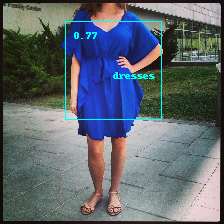

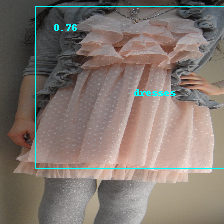

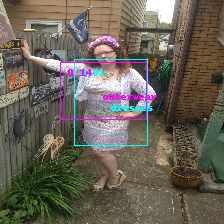

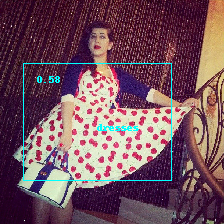

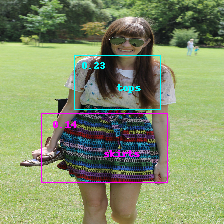

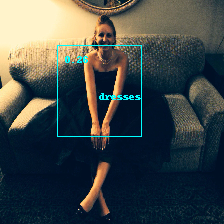

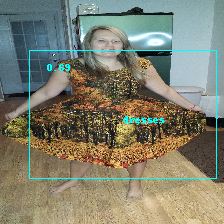

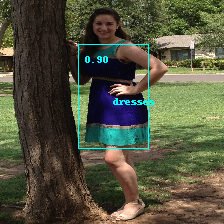

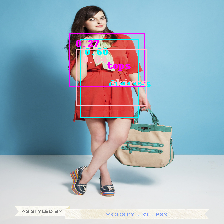

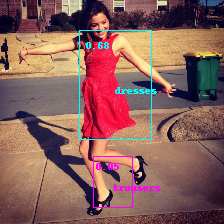

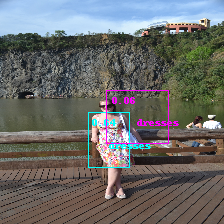

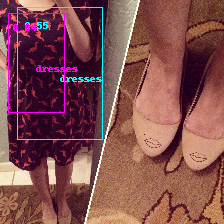

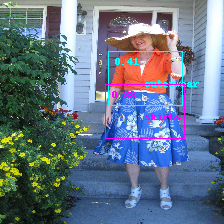

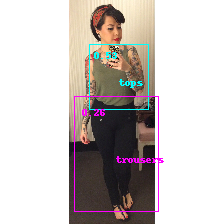

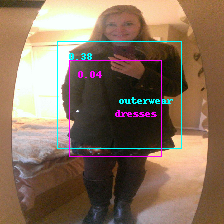

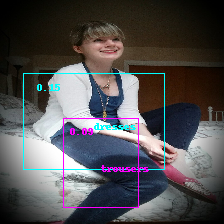

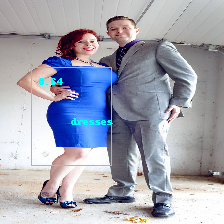

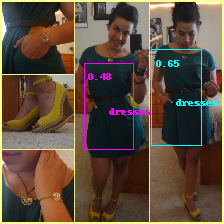

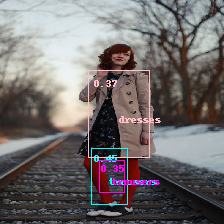

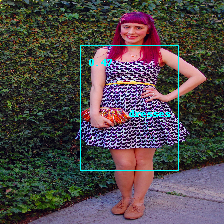

In [21]:
# Run this to visualize
rank_colors = ['cyan', 'magenta', 'pink']
det_threshold=0.
top_dets=3

start=0
end=20
for k in range(start,end):
  img_arr, label_cxywh = test_sequence_pickle[k]
  img_arr = img_arr[0]
  pil_img = PIL.Image.fromarray( (img_arr * 255.).astype(np.uint8) )
  W,H = pil_img.size
  pred_dict = model(np.array([img_arr]))
  preds = decode_tensor( pred_dict, aspect_ratios )
    
  # Post-processing
  preds.sort( key=lambda x:x[0], reverse=True )
  preds = [pred for pred in preds if pred[0] >= det_threshold]
  preds = preds[:top_dets]
  preds = nms(preds, iou_thresh=0.5)

  draw_img = pil_img.copy()
  draw = ImageDraw.Draw(draw_img)
  for i, pred in enumerate(preds):
    conf,cls,x,y,w,h = pred
    bb_x = int(x * W)
    bb_y = int(y * H)
    bb_w = int(w * W)
    bb_h = int(h * H)
    left = int(bb_x - bb_w / 2)
    top = int(bb_y - bb_h / 2)
    right = int(bb_x + bb_w / 2)
    bot = int(bb_y + bb_h / 2)
    cls_str = cat_list[cls-1]

    draw.rectangle(((left, top), (right, bot)), outline=rank_colors[i])
    draw.text((bb_x, bb_y), cls_str, fill=rank_colors[i])
    draw.text( ( int(left + bb_w*.1), int(top + bb_h*.1) ), '{:.2f}'.format(conf), fill=rank_colors[i] )

  display(draw_img)

# Generating detections

In [ ]:
# Generating detections on the folder of validation images
detections = []
det_threshold=0.
for i in tqdm(range(len(test_sequence))):
  img_id, dims, input_arr, _ = test_sequence[i]
  img_id = int(img_id[0])
  W,H = dims[0]

  # Here, I'm inferencing one-by-one, but you can batch it if you want it faster
  pred_dict = model(input_arr)
  preds = decode_tensor( pred_dict, aspect_ratios )

  # Post-processing
  preds = [pred for pred in preds if pred[0] >= det_threshold]
  preds.sort( key=lambda x:x[0], reverse=True )
  preds = preds[:100] # we only evaluate you on 100 detections per image

  for i, pred in enumerate(preds):
    conf,cat_id,x,y,w,h = pred
    left = W * (x - w/2.)
    left = round(left,1)
    top = H * (y - h/2.)
    top = round(top,1)
    width = W*w
    width = round(width,1)
    height = H*h
    height = round(height,1)
    conf = float(conf)
    cat_id = int(cat_id)
    detections.append( {'image_id':img_id, 'category_id':cat_id, 'bbox':[left, top, width, height], 'score':conf} )

with open('detections-7x7-14x14-top100-nonms.json', 'w') as f:
  json.dump(detections, f)

# Evaluation

In [2]:
# First, we need to install cocoapi to evaluate our detections
# This installation is a modified version of the original to suit this competition
! pip install git+https://github.com/jinmingteo/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/jinmingteo/cocoapi.git to /tmp/pip-req-build-cmzu09xy
  Running command git clone -q https://github.com/jinmingteo/cocoapi.git /tmp/pip-req-build-cmzu09xy
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=280208 sha256=d9e51b7bc23829de87ae12b4af1ff622dc693f11c1f63ace78e5470db3cef111
  Stored in directory: /tmp/pip-ephem-wheel-cache-rzvz6r8b/wheels/3c/e6/69/aab5d243383d4d2fafb024229a5d9517b005938de186d61b75
Successfully built pycocotools
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [4]:
# Get evaluation score against validation set
coco_gt = COCO(val_annotations)
coco_dt = coco_gt.loadRes('/kaggle/input/til2020-test/detections-7x7-14x14-top100.json')
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.77s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.31s).
Accumulating evaluation results...
DONE (t=2.00s).
 Average Precision  (AP) @[ IoU=0.20:0.50 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.30      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
